# Setup

In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
3964 MiB


# Model setup

In [13]:
# Should match the model used for training:
MASTER_MODEL = BertModel # Should match the model used for training
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'  # Should match the model used for training
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 150
class_names = ['negative', 'neutral', 'positive']
# class_names = ['neutral', 'negative', 'positive']


# Should be the path to the full dataset you want to apply the tuned model to:
# data = pd.read_csv("../archiveData/all_unlabeled_tweets_ecodes.csv", index_col=0, header=0)
data = pd.read_csv("../archiveData/tweets_unlabeled_ecodes.csv", index_col=0, header=0)

In [14]:
print(data.shape)  #(200084, 5)
print(data['ContentClean'].iloc[13])
data.head()

(200084, 3)
 grinning_face_with_sweat_e face_with_tears_of_joy_e So what do you appreciate that Biden has done... leaving Americans behind but bringing 78,000 unvetted Afghan people to US...that are now missing, or the open border - more terrorist in America. You sound more like a sadist. Gas prices thumbs_up_e if you don't drive. No groceries.


,id_stable,Date,ContentClean
0,19167,2022-02-11 00:54:35+00:00,"What are we doing to secure our #Afghan SIVs, ..."
1,174397,2021-08-14 00:51:43+00:00,Please help get this guidance out there: help ...
2,166369,2021-08-16 10:34:37+00:00,"A decade ago, We saw biggest humanitarian & re..."
3,133951,2021-08-20 20:42:10+00:00,Chaired #UnitingChurch leaders meeting Friday ...
4,171885,2021-08-15 11:16:10+00:00,The tragedy unfolding in Afghanistan is terrif...


In [15]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = MASTER_MODEL.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

# Use the tuned model on full dataset

In [16]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def infer_model(review_texts):
    res = []
    for review_text in review_texts:
        encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        )
        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)

        res.append(class_names[prediction])
    return res


def infer_model2(review_text):
    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    # print(output[0][0].item(), output[0][1].item(), output[0][2].item(), _, prediction)
    return class_names[prediction], output[0][0].item(), output[0][1].item(), output[0][2].item()


Test out the model

In [18]:
review_texts = ["Refugee is another name for terrorist","we have an obligation to them; I'm glad we are doing something for these people.", "I don't care what happens to the translators.", "1000 refugees entered Iowa."]
predictions = infer_model(review_texts)
for i, review_text in enumerate(review_texts):
    print(f'{predictions[i]} : {review_text}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


negative : Refugee is another name for terrorist
positive : we have an obligation to them; I'm glad we are doing something for these people.
negative : I don't care what happens to the translators.
positive : 1000 refugees entered Iowa.


Now run it on the full dataset

In [19]:
data['sentiment'], data['negative'], data['neutral'], data['positive'] = zip(*data.ContentClean.apply(infer_model2))

data.to_csv("../archiveData/temp_full_pred.csv")
data.head(10)

c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,id_stable,Date,ContentClean,sentiment,negative,neutral,positive
0,19167,2022-02-11 00:54:35+00:00,"What are we doing to secure our #Afghan SIVs, ...",negative,6.457653,-2.310253,-2.114391
1,174397,2021-08-14 00:51:43+00:00,Please help get this guidance out there: help ...,positive,-3.049870,-3.270198,5.668267
2,166369,2021-08-16 10:34:37+00:00,"A decade ago, We saw biggest humanitarian & re...",positive,1.051822,-3.792543,3.822897
3,133951,2021-08-20 20:42:10+00:00,Chaired #UnitingChurch leaders meeting Friday ...,positive,1.102365,-3.589267,2.322366
4,171885,2021-08-15 11:16:10+00:00,The tragedy unfolding in Afghanistan is terrif...,negative,5.211598,-3.231716,-1.783538
5,98984,2021-08-31 16:01:44+00:00,All Americans living in Afghanistan were told ...,negative,6.113424,-2.356766,-1.998074
6,189052,2021-06-30 19:03:47+00:00,Thank you so much Mr.wicker. Please heard thos...,negative,3.871863,-3.862699,0.261751
7,28950,2022-01-06 14:30:28+00:00,Afghan refugee who 'raped and murdered' 13-yea...,negative,6.333053,-2.434183,-1.906107
8,109872,2021-08-27 11:11:31+00:00,That's a lot of supposition without any eviden...,negative,6.014639,-2.538473,-2.693110
9,71603,2021-09-17 19:16:02+00:00,"MT is welcoming to others, and willing to help...",positive,1.420896,-3.215072,1.914068


In [11]:
data.tail()

,id_stable,Date,Content,ContentClean,Flag,sentiment,negative,neutral,positive
200079,106134,2021-08-28 15:34:42+00:00,Did you miss our Operation Welcome Afghan Alli...,Did you miss our Operation Welcome Afghan Alli...,no,neutral,-3.240225,4.401594,-1.172779
200080,94022,2021-09-02 11:59:32+00:00,"£250,000 will be available through the Scottis...","£250,000 will be available through the Scottis...",no,positive,-4.218745,-2.475329,5.682626
200081,182463,2021-07-26 12:30:15+00:00,@Ho34980636 @AmrullahSaleh2 Pakistan is dying ...,Pakistan is dying state and Afghanistan is ris...,no,negative,5.483119,-1.427563,-2.934944
200082,95209,2021-09-01 21:40:38+00:00,Pentagon chief says SIV program was not design...,Pentagon chief says SIV program was not design...,no,neutral,-2.693552,5.702044,-3.132891
200083,83631,2021-09-08 05:30:05+00:00,[ Stigmabase IE ] Northern Ireland Executive a...,[ Stigmabase IE ] Northern Ireland Executive a...,no,neutral,-2.517895,5.261896,-2.597260


In [ ]:
# Save it to a permanent file.  ### Add it to .gitignore
data.to_csv("../dataBert/full_pred_23June.csv")

In [222]:
data = pd.read_csv("../dataBert/full_pred_23June.csv", index_col=0, header=0)

In [223]:
data["Date"] = pd.to_datetime(data['Date']).dt.date
data["Date"] = pd.to_datetime(data['Date'])
data["year"] = pd.DatetimeIndex(data['Date']).year  #pd.DatetimeIndex(df['ArrivalDate']).year

data.sort_values(by="Date", axis=0, ascending=True, inplace=True)
data.reset_index(inplace=True)

data["week"] = data['Date'].dt.isocalendar().week   #datetime.date(2010, 6, 16).isocalendar()[1]

data

,index,id_stable,Date,ContentClean,sentiment,negative,neutral,positive,year,week
0,55140,198763,2021-01-01,That picture is of an Afghan refugee who was s...,negative,6.170747,-1.974321,-2.953276,2021,53
1,173427,198765,2021-01-01,Shame on a man and on a regime that raises its...,negative,6.316507,-2.363165,-2.664772,2021,53
2,19882,198771,2021-01-01,"Also, there are many countries who are not onl...",negative,5.943663,-2.566618,-2.767907,2021,53
3,58354,198764,2021-01-01,"The Europeans, Canadians, the Aussies, the Jap...",negative,6.107044,-2.219691,-2.457027,2021,53
4,73807,198770,2021-01-01,“They commanded us to go to Lipa. We don’t kno...,negative,6.006198,-1.722674,-1.783321,2021,53
...,...,...,...,...,...,...,...,...,...,...
200079,190062,21,2022-04-27,Would you or I of escaped jail???? Afghan asyl...,negative,5.866843,-2.097936,-2.034228,2022,17
200080,165523,47,2022-04-27,82.4 million displaced people and the U.K. tak...,negative,3.792255,-0.263868,-2.806779,2022,17
200081,22260,36,2022-04-27,"Where are the complaints about vetting, as wit...",negative,6.140977,-2.297522,-2.165749,2022,17
200082,175971,26,2022-04-27,Support innocent souls of Afghanistan like chi...,positive,-2.507536,-3.338202,5.240273,2022,17


In [224]:
index_nos = []
for i, y, w in zip(data.index, data["year"], data["week"]):
    if (y == 2021) and (w == 53):
        index_nos.append(i)
for i in index_nos:
    data["week"].iloc[i] = 0

index_nos = []
for i, y, w in zip(data.index, data["year"], data["week"]):
    if (y == 2022):
        index_nos.append(i)
        data["week"].iloc[i] = w + 52
# for i in index_nos:
#     data["week"].iloc[i] = 

index_nos = []
for i, y, w in zip(data.index, data["year"], data["week"]):
    if (y == 2022) and (w == 104):
        index_nos.append(i)
for i in index_nos:
    data["week"].iloc[i] = 52

data

,index,id_stable,Date,ContentClean,sentiment,negative,neutral,positive,year,week
0,55140,198763,2021-01-01,That picture is of an Afghan refugee who was s...,negative,6.170747,-1.974321,-2.953276,2021,0
1,173427,198765,2021-01-01,Shame on a man and on a regime that raises its...,negative,6.316507,-2.363165,-2.664772,2021,0
2,19882,198771,2021-01-01,"Also, there are many countries who are not onl...",negative,5.943663,-2.566618,-2.767907,2021,0
3,58354,198764,2021-01-01,"The Europeans, Canadians, the Aussies, the Jap...",negative,6.107044,-2.219691,-2.457027,2021,0
4,73807,198770,2021-01-01,“They commanded us to go to Lipa. We don’t kno...,negative,6.006198,-1.722674,-1.783321,2021,0
...,...,...,...,...,...,...,...,...,...,...
200079,190062,21,2022-04-27,Would you or I of escaped jail???? Afghan asyl...,negative,5.866843,-2.097936,-2.034228,2022,69
200080,165523,47,2022-04-27,82.4 million displaced people and the U.K. tak...,negative,3.792255,-0.263868,-2.806779,2022,69
200081,22260,36,2022-04-27,"Where are the complaints about vetting, as wit...",negative,6.140977,-2.297522,-2.165749,2022,69
200082,175971,26,2022-04-27,Support innocent souls of Afghanistan like chi...,positive,-2.507536,-3.338202,5.240273,2022,69


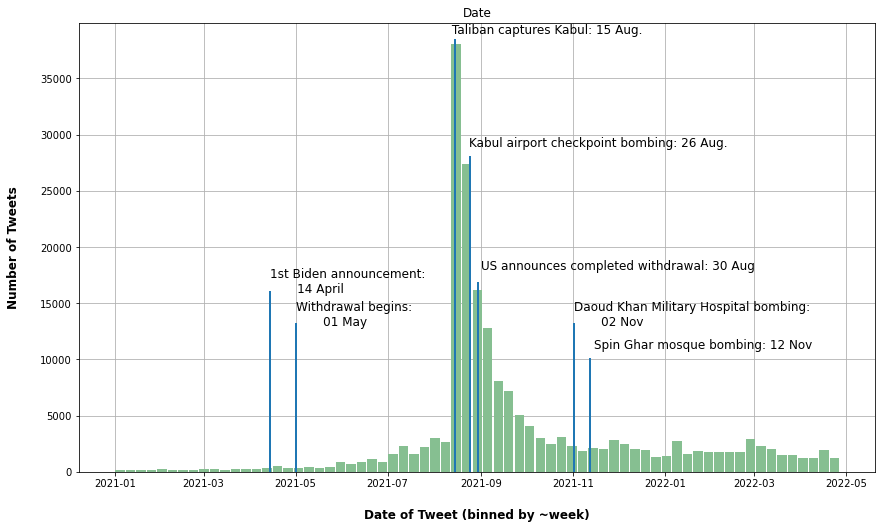

In [265]:
# Plot a stacked histogram
colors = ["#01BEFE", "#FFDD00", "#FF7D00"]#, "#FF006D", "#ADFF02", "#8F00FF"]  #'#86bf91'

ax = data.hist(column="Date", bins=69, figsize=(14, 8), zorder=2, rwidth=0.9, color="#86bf91")  
ax = ax[0]
for x in ax:
    # Set x-axis label
    x.set_xlabel("Date of Tweet (binned by ~week)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Tweets", labelpad=20, weight='bold', size=12)

plt.axvline(dt.datetime(2021, 4, 14), ymax=0.40, linewidth=2)
plt.text(dt.datetime(2021, 4, 14), 16000, "1st Biden announcement:\n       14 April", fontsize=12, rotation=0)

plt.axvline(dt.datetime(2021, 5, 1), ymax=0.33, linewidth=2)
plt.text(dt.datetime(2021, 5, 1), 13000, "Withdrawal begins:\n       01 May", fontsize=12, rotation=0)

plt.axvline(dt.datetime(2021, 8, 15), ymax=.96, linewidth=2)
plt.text(dt.datetime(2021, 8, 10), 39000, " Taliban captures Kabul: 15 Aug.", fontsize=12, rotation=0)

plt.axvline(dt.datetime(2021, 8, 25), ymax=0.70, linewidth=2)
plt.text(dt.datetime(2021, 8, 24), 29000, "Kabul airport checkpoint bombing: 26 Aug.", fontsize=12, rotation=0)

plt.axvline(dt.datetime(2021, 8, 30), ymax=0.42, linewidth=2)
plt.text(dt.datetime(2021, 9, 1), 18000, "US announces completed withdrawal: 30 Aug", fontsize=12, rotation=0)

# plt.axvline(dt.datetime(2021, 9, 9), ymax=0.62, linewidth=2)
# plt.text(dt.datetime(2021, 9, 9), 21000, "Kabul International Airport reopens: 09 Sept", fontsize=12, rotation=90)

plt.axvline(dt.datetime(2021, 11, 2), ymax=0.33, linewidth=2)
plt.text(dt.datetime(2021, 11, 2), 13000, "Daoud Khan Military Hospital bombing:\n       02 Nov", fontsize=12, rotation=0)

plt.axvline(dt.datetime(2021, 11, 12), ymax=0.25, linewidth=2)
plt.text(dt.datetime(2021, 11, 15), 11000, "Spin Ghar mosque bombing: 12 Nov", fontsize=12, rotation=0)

# plt.axvline(dt.datetime(2021, 12, 26), ymax=0.62, linewidth=2)
# plt.text(dt.datetime(2021, 12, 26), 21000, "Taliban dissolves Afghanistan's Independent Election Commission: 26 Dec", rotation=45)

plt.gcf().subplots_adjust(left=0.11, bottom=0.1, )
plt.savefig('tweetsPerMonth.png')

In [ ]:
cross_tab_prop = pd.crosstab(index=data['week'],
                             columns=data['sentiment'],
                             normalize="index")

cross_tab_prop.head()

<AxesSubplot:xlabel='week'>

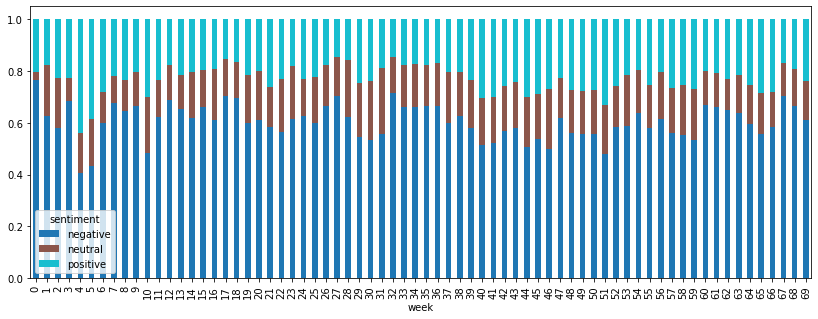

In [266]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(14, 5))

In [257]:
cross_tab_data = pd.crosstab(index=data['week'],
                        columns=data['sentiment'])
cross_tab_data.head()

sentiment,negative,neutral,positive
week,,,
0,52,2,14
1,77,24,22
2,105,35,41
3,118,16,39
4,90,34,97


In [141]:
grouped_data = cross_tab_data.copy()
grouped_data = grouped_data.stack(level=0)
grouped_data.head()

Date        sentiment
2021-01-01  negative     11
            neutral       0
            positive      5
2021-01-02  negative     14
            neutral       1
dtype: int64